In [1]:
import time

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from IPython import display

# %matplotlib notebook

In [2]:
dataset = 'horse2zebra'
# dataset = 'apple2orange'

data = tfds.load('cycle_gan/' + dataset)
train_x = data['trainA']
train_y = data['trainB']
test_x = data['testA']
test_y = data['testB']

print('train_x: ', train_x)
print('train_y: ', train_y)
print('test_x: ', test_x)
print('test_y: ', test_y)

train_x:  <PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
train_y:  <PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
test_x:  <PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
test_y:  <PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>


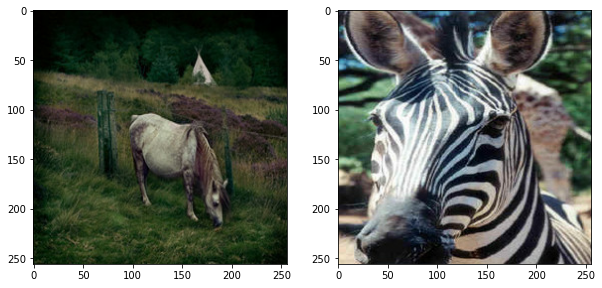

In [3]:
x = next(iter(test_x))
y = next(iter(test_y))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x['image'])

plt.subplot(1, 2, 2)
plt.imshow(y['image'])

plt.show()

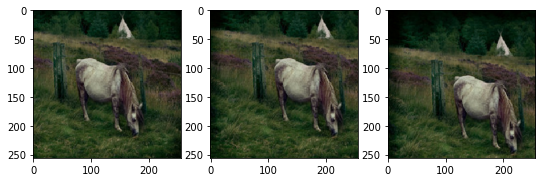

In [4]:
IMAGE_SIZE = 256

def normalize(image):
    return tf.cast(image, tf.float32) / 127.5 - 1.0


def resize(image, width, height):
    image = tf.image.resize(image, [height, width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image


@tf.function
def random_jitter(image):
    image = resize(image, 300, 300)
    image = tf.image.random_crop(image, [IMAGE_SIZE, IMAGE_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    return normalize(image)


plt.figure(figsize=(9, 3))
for i in range(3):
    distorted_apple = random_jitter(x['image'])
    plt.subplot(1, 3, i+1)
    plt.imshow(distorted_apple * 0.5 + 0.5)
plt.show()

In [5]:
BATCH_SIZE = 1

def train_pipeline(entry):
    return random_jitter(entry['image'])


def test_pipeline(entry):
    image = resize(entry['image'], IMAGE_SIZE, IMAGE_SIZE)
    return normalize(image)


SHUFFLE_SIZE = 500
train_x_ds = train_x.shuffle(SHUFFLE_SIZE).map(train_pipeline).batch(BATCH_SIZE, drop_remainder=True)
train_y_ds = train_y.shuffle(SHUFFLE_SIZE).map(train_pipeline).batch(BATCH_SIZE, drop_remainder=True)

test_x_ds = test_x.shuffle(SHUFFLE_SIZE).map(test_pipeline).batch(BATCH_SIZE, drop_remainder=True)
test_y_ds = test_y.shuffle(SHUFFLE_SIZE).map(test_pipeline).batch(BATCH_SIZE, drop_remainder=True)

print(train_x_ds)
print(train_y_ds)
print(test_x_ds)
print(test_y_ds)

<BatchDataset shapes: (1, 256, 256, 3), types: tf.float32>
<BatchDataset shapes: (1, 256, 256, 3), types: tf.float32>
<BatchDataset shapes: (1, 256, 256, 3), types: tf.float32>
<BatchDataset shapes: (1, 256, 256, 3), types: tf.float32>


In [6]:
kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


def residual(x,
             activation,
             kernel_size=(3, 3),
             strides=(1, 1)):
    input_tensor = x
    d = x.shape[-1]
    x = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], 'REFLECT')
    x = layers.Conv2D(d,
                      kernel_size,
                      strides=strides,
                      padding='valid',
                      kernel_initializer=kernel_initializer,
                      use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)
    x = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], 'REFLECT')
    x = layers.Conv2D(d,
                      kernel_size,
                      strides=strides,
                      kernel_initializer=kernel_initializer,
                      padding='valid',
                      use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(x,
               filters,
               activation,
               kernel_size=(3, 3),
               strides=(2, 2)):
    x = layers.Conv2D(filters,
                      kernel_size,
                      strides=strides,
                      kernel_initializer=kernel_initializer,
                      padding='same',
                      use_bias=False)(x)
    
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(x,
             filters,
             activation,
             kernel_size=(3, 3),
             strides=(2, 2),
             padding="same"):
    x = layers.Conv2DTranspose(filters,
                               kernel_size,
                               strides=strides,
                               padding='same',
                               kernel_initializer=kernel_initializer,
                               use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x



def build_generator(num_downsampling_blocks=2,
                    num_residual_blocks=9,
                    num_upsample_blocks=2):
    input_images = keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    x = tf.pad(input_images, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    filters = 64
    x = keras.layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.ReLU()(x)
    
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.ReLU())
    
    for _ in range(num_residual_blocks):
        x = residual(x, activation=layers.ReLU())
    
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.ReLU())

    x = tf.pad(x, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)
    
    model = keras.models.Model(inputs=[input_images], outputs=[x])
    return model


def build_discriminator(num_downsampling=3):
    input_images = layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    filters = 64
    x = layers.Conv2D(filters,
                      (4, 4),
                      strides=(2, 2),
                      padding='same',
                      kernel_initializer=kernel_initializer)(input_images)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(num_downsampling):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(x,
                           filters=num_filters,
                           activation=layers.LeakyReLU(0.2),
                           kernel_size=(4, 4),
                           strides=(2, 2))
        else:
            x = downsample(x,
                           filters=num_filters,
                           activation=layers.LeakyReLU(0.2),
                           kernel_size=(4, 4),
                           strides=(1, 1))

    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)

    model = keras.models.Model(inputs=[input_images], outputs=[x])
    return model



keras.backend.clear_session()
G = build_generator()
F = build_generator()
G.summary()
F.summary()


Dg = build_discriminator()
Df = build_discriminator()
Dg.summary()
Df.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf.compat.v1.pad (TFOpLambda)   (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9408        tf.compat.v1.pad[0][0]           
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [8]:
EPOCHS = 110
STEPS_PER_EPOCH = len(train_x_ds)
DECAY_STEPS = EPOCHS * STEPS_PER_EPOCH

# optimizers
g_opt = keras.optimizers.Adam(keras.optimizers.schedules.CosineDecay(2.5e-4, DECAY_STEPS, alpha=1e-6), beta_1=0.5)
f_opt = keras.optimizers.Adam(keras.optimizers.schedules.CosineDecay(2.5e-4, DECAY_STEPS, alpha=1e-6), beta_1=0.5)
dg_opt = keras.optimizers.Adam(keras.optimizers.schedules.CosineDecay(2.5e-4, DECAY_STEPS, alpha=1e-6), beta_1=0.5)
df_opt = keras.optimizers.Adam(keras.optimizers.schedules.CosineDecay(2.5e-4, DECAY_STEPS, alpha=1e-6), beta_1=0.5)

In [11]:
ALPHA = 10

def image_loss(y_true, y_pred):
    return keras.losses.MeanAbsoluteError()(y_true, y_pred)

def class_loss(y_true, y_pred):
    # return keras.losses.BinaryCrossentropy(from_logits=True)(y_true, y_pred)
    return keras.losses.MeanSquaredError()(y_true, y_pred)

def discriminator_loss(fake, real):
    loss = class_loss(tf.zeros_like(fake), fake) + class_loss(tf.ones_like(real), real)
    return loss / 2.0

def generator_loss(y, y_same, fake):
    return ALPHA / 2.0 * image_loss(y, y_same) + class_loss(tf.ones_like(fake), fake)

def cycle_loss(y, cycled_y):
    return ALPHA * image_loss(y, cycled_y)


@tf.function(jit_compile=True)
def train_step(x, y):
    """
    G: x -> y
    F: y -> x
    Dg: y -> 1, y_hat -> 0
    Df: x -> 1, x_hat -> 0
    """
    
    with tf.GradientTape(persistent=True) as tape:
        y_hat = G(x, training=True)
        x_hat = F(y, training=True)
        same_y = G(y, training=True)
        same_x = F(x, training=True)
        dg_fake = Dg(y_hat, training=True)
        df_fake = Df(x_hat, training=True)
        dg_real = Dg(y, training=True)
        df_real = Df(x, training=True)
        cycle_x = F(y_hat, training=True)
        cycle_y = G(x_hat, training=True)
        
        total_g_loss = generator_loss(y, same_y, dg_fake) + cycle_loss(y, cycle_y)
        total_f_loss = generator_loss(x, same_x, df_fake) + cycle_loss(x, cycle_x)
        dg_loss = discriminator_loss(dg_fake, dg_real)
        df_loss = discriminator_loss(df_fake, df_real)
        
    g_grad = tape.gradient(total_g_loss, G.trainable_variables)
    f_grad = tape.gradient(total_f_loss, F.trainable_variables)
    dg_grad = tape.gradient(dg_loss, Dg.trainable_variables)
    df_grad = tape.gradient(df_loss, Df.trainable_variables)
    
    g_opt.apply_gradients(zip(g_grad, G.trainable_variables))
    f_opt.apply_gradients(zip(f_grad, F.trainable_variables))
    dg_opt.apply_gradients(zip(dg_grad, Dg.trainable_variables))
    df_opt.apply_gradients(zip(df_grad, Df.trainable_variables))
    
    return total_g_loss, total_f_loss, dg_loss, df_loss


train_ds = tf.data.Dataset.zip((train_x_ds, train_y_ds))
train_iter = iter(train_ds)
x, y = next(train_iter)
train_step(x, y)

(<tf.Tensor: shape=(), dtype=float32, numpy=6.084944>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.9097366>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4996851>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.49845707>)

In [12]:
%timeit train_step(x, y)

267 ms ± 9.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


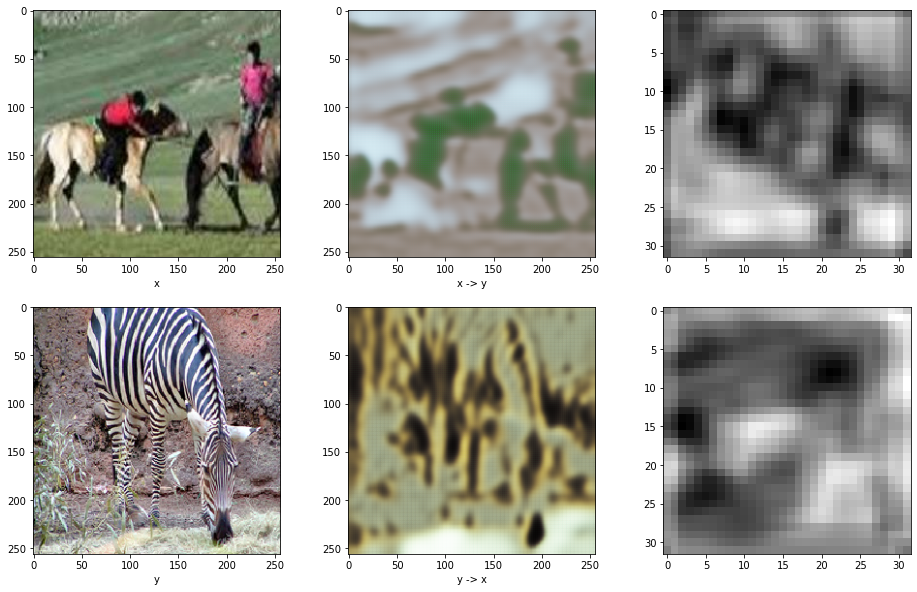

In [13]:
def generate_images(x, y):
    fake_y = G(x, training=False)
    fake_x = F(y, training=False)
    dg_map = Dg(fake_x, training=False)
    df_map = Df(fake_y, training=False)
    
    plt.subplot(2, 3, 1)
    plt.imshow(x[0] * 0.5 + 0.5)
    plt.xlabel('x')
    
    plt.subplot(2, 3, 2)
    plt.imshow(fake_y[0] * 0.5 + 0.5)
    plt.xlabel('x -> y')
    
    plt.subplot(2, 3, 3)
    plt.imshow(dg_map[0, :, :, 0], cmap='gray')
    
    plt.subplot(2, 3, 4)
    plt.imshow(y[0] * 0.5 + 0.5)
    plt.xlabel('y')
    
    plt.subplot(2, 3, 5)
    plt.imshow(fake_x[0] * 0.5 + 0.5)
    plt.xlabel('y -> x')
    
    plt.subplot(2, 3, 6)
    plt.imshow(df_map[0, :, :, 0], cmap='gray')


plt.figure(figsize=(16, 10))
x, y = next(train_iter)
generate_images(x, y)
plt.show()

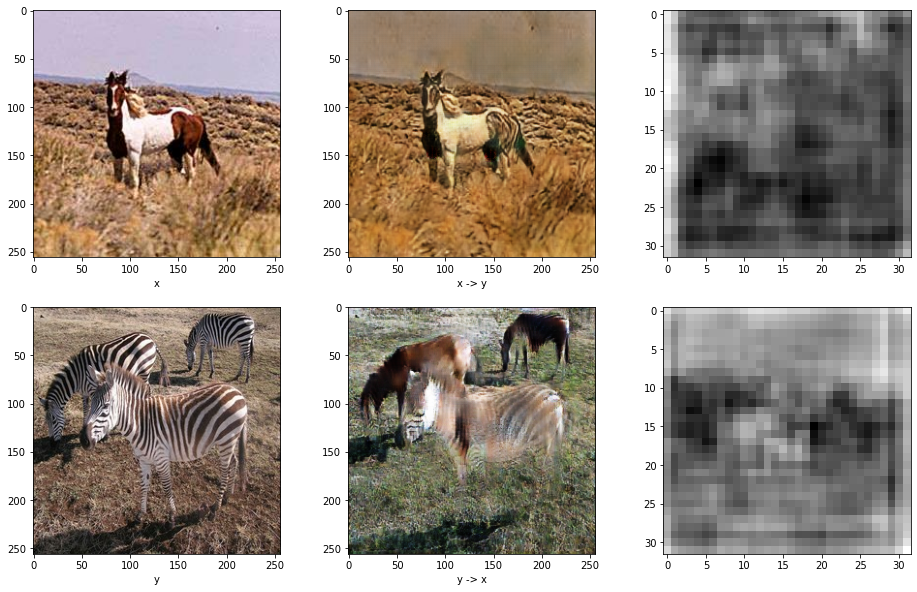

time used last epoch:  283.48456716537476
epoch:  109
1066. g_loss: 2.358054, f_loss: 2.116433, dg_loss: 0.116011, df_loss: 0.174728

In [14]:
def train(train_ds, test_ds):
    test_repeat = test_ds.repeat()
    test_iter = iter(test_repeat)
    time_used = 0
    for epoch in range(EPOCHS):
        display.clear_output(wait=True)
        
        test_x, test_y = next(test_iter)
        plt.figure(figsize=(16, 10))
        generate_images(test_x, test_y)
        plt.show()
        
        if time_used:
            print('time used last epoch: ', time_used)
        
        print('epoch: ', epoch)
        start = time.time()
        losses = [[] for _ in range(5)]
        step = 0
        for x, y in train_ds:
            l = train_step(x, y)
            for i in range(4):
                losses[i].append(l[i].numpy())
    
            print('\r%d. g_loss: %f, f_loss: %f, dg_loss: %f, df_loss: %f' %
                  (step, np.mean(losses[0]), np.mean(losses[1]), np.mean(losses[2]),
                   np.mean(losses[3])), end='')
            step += 1
        time_used = time.time() - start


test_ds = tf.data.Dataset.zip((test_x_ds, test_y_ds))
train(train_ds, test_ds)

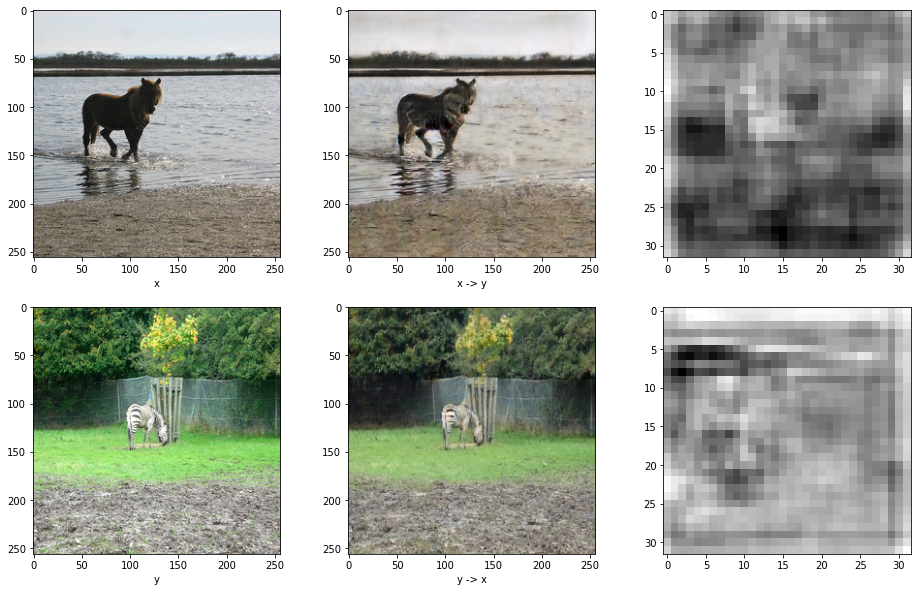

In [15]:
test_repeat_ds = test_ds.repeat()
test_iter = iter(test_repeat_ds)

def show_image():
    plt.figure(figsize=(16, 10))
    horses, zebras = next(test_iter)
    generate_images(horses, zebras)
    plt.show()


show_image()

In [16]:
model_path = f'saved_models/cycle_gan/{dataset}'

G.save(f'{model_path}/G')
F.save(f'{model_path}/F')
Dg.save(f'{model_path}/Dg')
Df.save(f'{model_path}/Df')

INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/G/assets


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/G/assets
/home/kiddos/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/F/assets


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/F/assets
/home/kiddos/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/Dg/assets


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/Dg/assets


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/Df/assets


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/Df/assets


In [17]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('checkpoint/%s/%s.1.checkpoint' % (dataset, dataset))

'checkpoint/horse2zebra/horse2zebra.1.checkpoint-1'

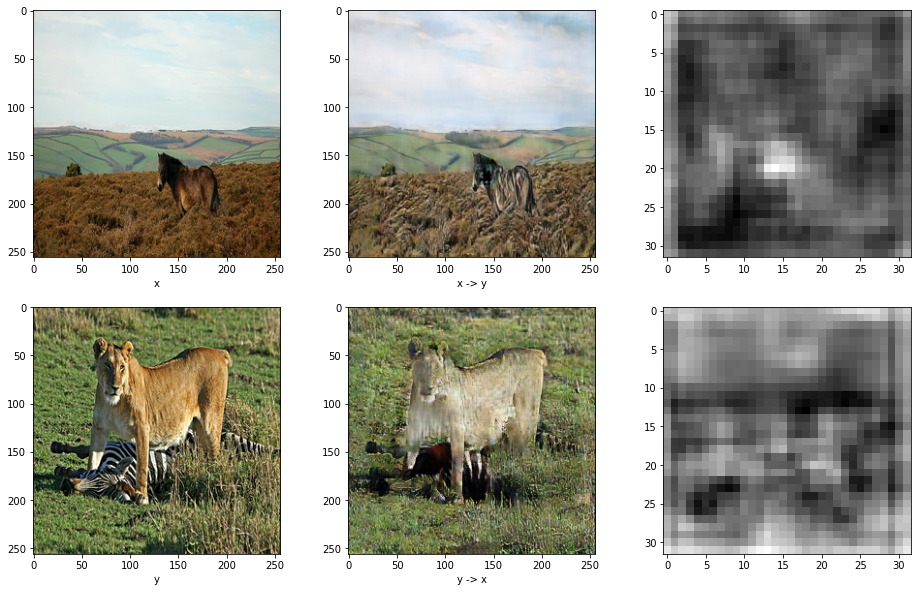

In [18]:
show_image()

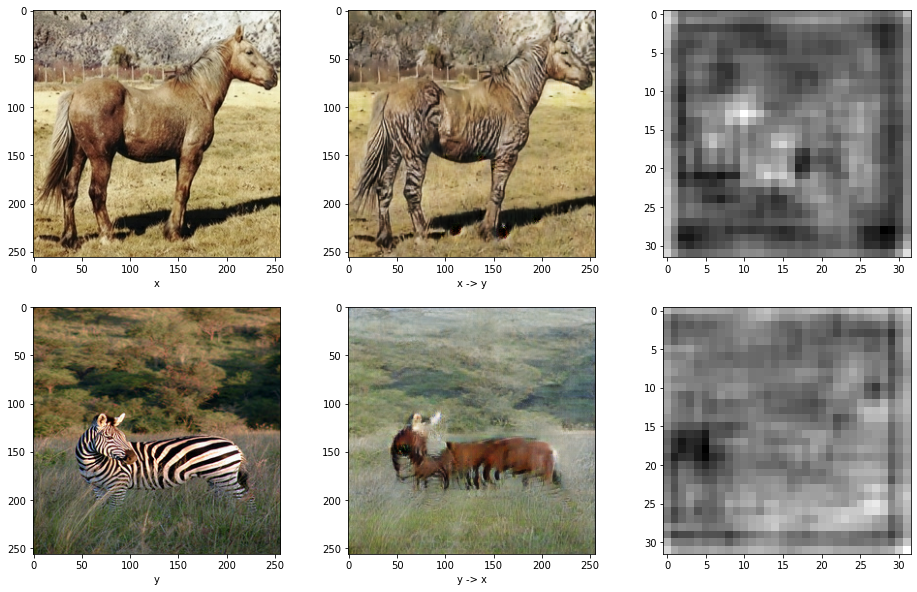

In [19]:
show_image()

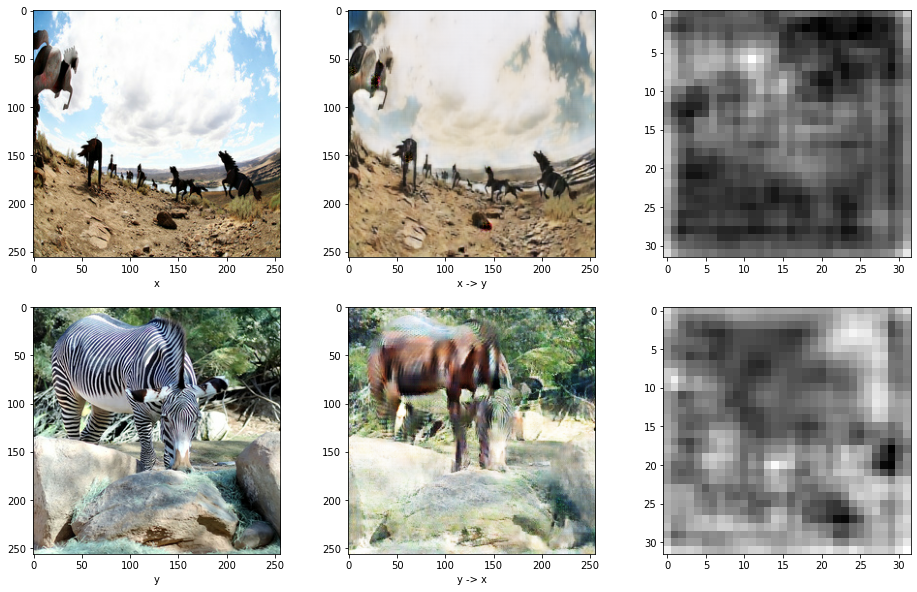

In [20]:
show_image()

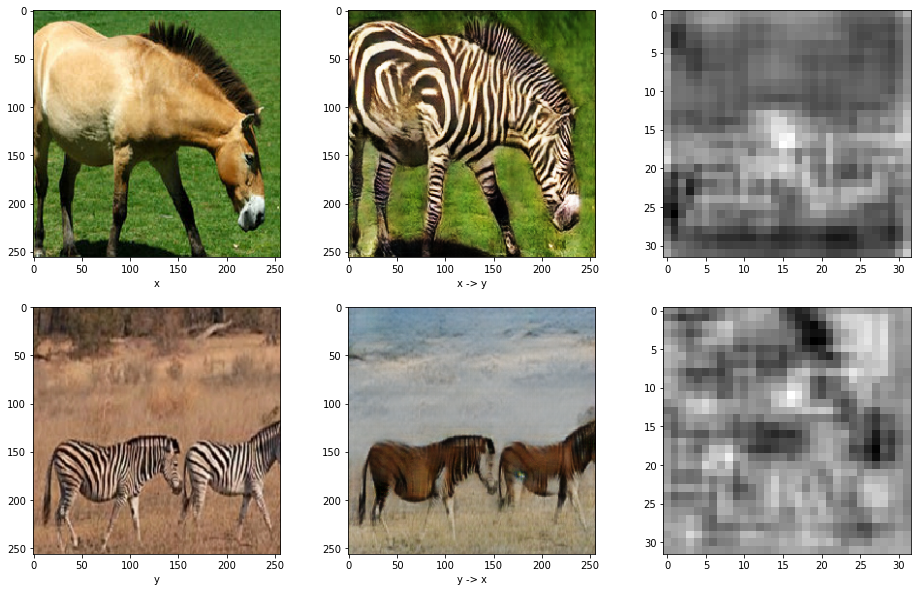

In [21]:
train_repeat_ds = train_ds.repeat()
train_repeat_iter = iter(train_repeat_ds)

def show_train_image():
    plt.figure(figsize=(16, 10))
    horses, zebras = next(train_repeat_iter)
    generate_images(horses, zebras)
    plt.show()


show_train_image()

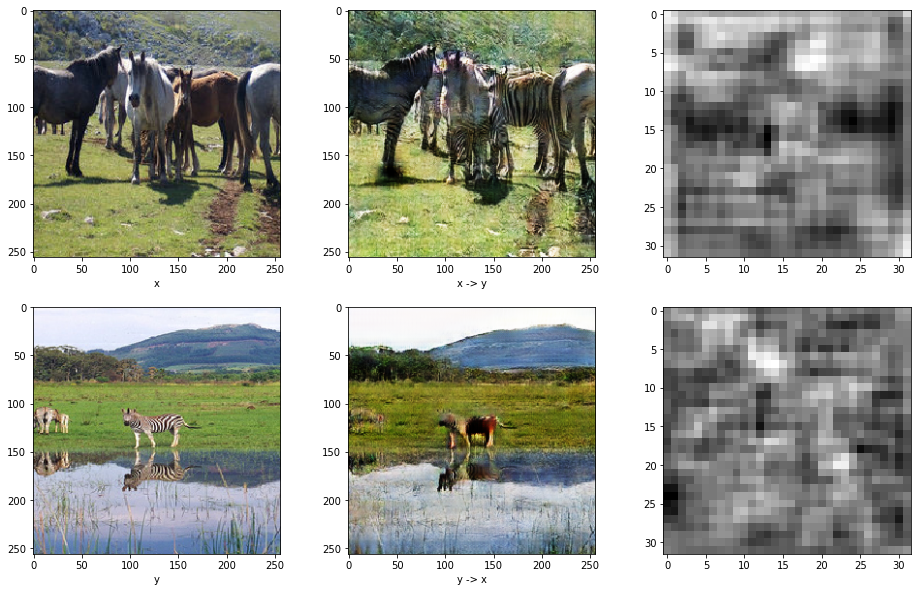

In [22]:
show_train_image()

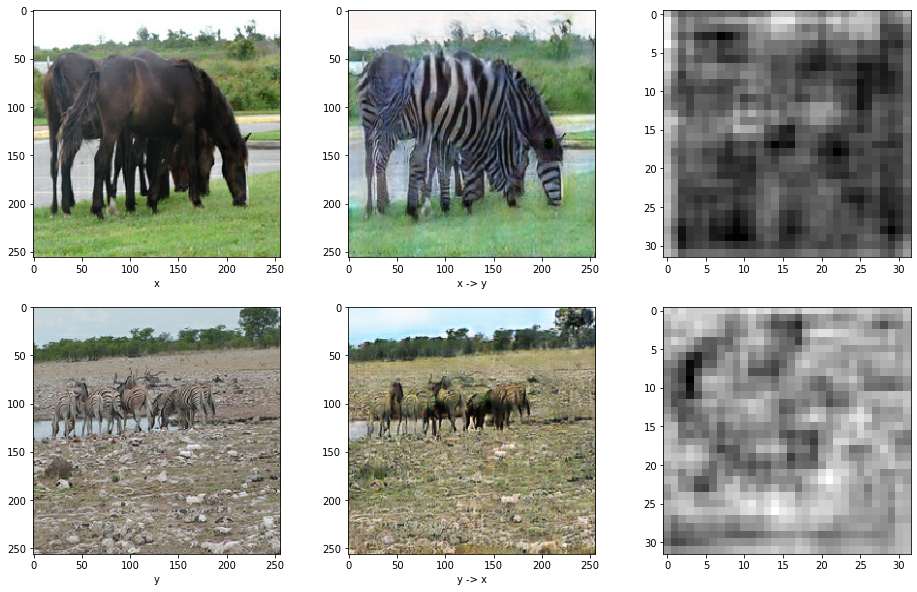

In [23]:
show_train_image()

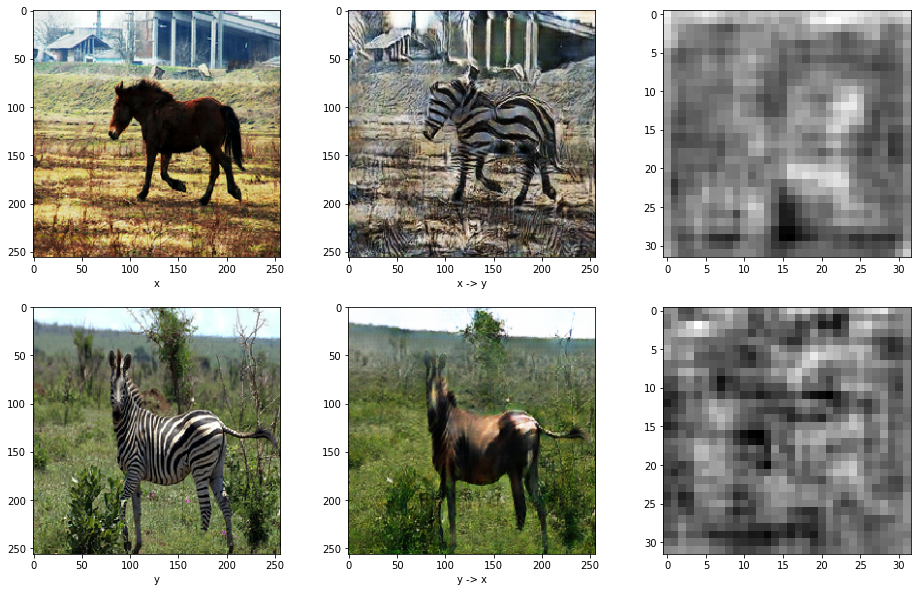

In [24]:
show_train_image()